[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.

We built up to a Chatbot with external memory that can sustain long-running conversations.

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways.

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution.

In [6]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("Open ai API key to be used here")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x.

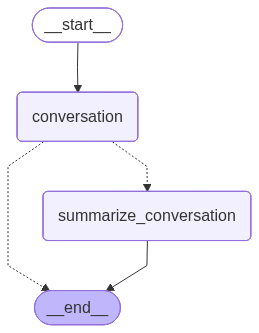

In [1]:
# ==========================================
#  OPENAI API KEY SETUP
# ==========================================
import os
os.environ["OPENAI_API_KEY"] = "open ai API key is to be used here"  # 👈 Enter your API key

# ==========================================
#  IMPORTS
# ==========================================
from IPython.display import Image, display
from typing import Literal
import time, sys

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# ==========================================
#  LLM INITIALIZATION
# ==========================================
model = ChatOpenAI(model="gpt-4o", temperature=0)

# ==========================================
#  STATE DEFINITION
# ==========================================
class State(MessagesState):
    summary: str
    feedback: str
    sentiment: str  # New field for visually different output

# ==========================================
# 💬 NODE: Conversation with Enhanced Streaming
# ==========================================
def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")
    feedback = state.get("feedback", "")
    sentiment = state.get("sentiment", "")

    system_content = " Conversation Context:\n"
    if summary:
        system_content += f"- Summary: {summary}\n"
    if feedback:
        system_content += f"- User Feedback: {feedback}\n"
    if sentiment:
        system_content += f"- Sentiment from last round: {sentiment}\n"

    messages = [SystemMessage(content=system_content)] + state["messages"]

    print("\n🔹 Streaming started from [conversation node] 🔹\n")
    sys.stdout.flush()

    response = model.stream(messages, config=config)
    full_text = ""
    token_counter = 0

    for chunk in response:
        if chunk.content:
            # Visually chunk tokens in groups for distinct display
            print(chunk.content, end="", flush=True)
            full_text += chunk.content
            token_counter += 1
            if token_counter % 10 == 0:
                print(" •", end="", flush=True)
                time.sleep(0.1)

    print("\n\n✅ Streaming complete for [conversation node]\n")
    return {"messages": [HumanMessage(content=full_text)]}

# ==========================================
# 🧾 NODE: Summarization with Context Tone
# ==========================================
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    summary_message = (
        f"Summarize the following discussion clearly and briefly. "
        f"Current summary: {summary if summary else 'None yet'}"
    )

    messages = state["messages"] + [HumanMessage(content=summary_message)]

    print("\n🟢 Generating summary stream from [summarize_conversation node]\n")
    response = model.stream(messages)
    summary_text = ""

    for chunk in response:
        if chunk.content:
            print(chunk.content, end="", flush=True)
            summary_text += chunk.content

    print("\n\n Summary generation completed.\n")

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": summary_text, "messages": delete_messages, "sentiment": "neutral"}

# ==========================================
#  CONDITIONAL FLOW CONTROL
# ==========================================
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    messages = state["messages"]
    if len(messages) > 5:
        return "summarize_conversation"
    return END

# ==========================================
#  GRAPH WORKFLOW CREATION
# ==========================================
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# ==========================================
#  MEMORY & GRAPH COMPILATION
# ==========================================
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# ==========================================
# 📈 GRAPH VISUALIZATION
# ==========================================
display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
!pip install -U langchain langchain-core langchain-openai langgraph langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27
ERROR: pip's dependency resolver does not currently t

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):

* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [ ]:
!pip install -U langchain-community


In [ ]:
# === Imports ===
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END

# === Step 1: Define conversation state ===
class ConversationState(dict):
    messages: list

# === Step 2: Define mock model ===
class MockLLM:
    def __init__(self):
        self.responses = [
            "Hello! I'm your AI assistant. How can I help you today?",
            "Sure! Here's a summary of our discussion so far.",
            "Glad I could help! Anything else you'd like to know?"
        ]
        self.index = 0

    def invoke(self, messages, config=None):
        response = self.responses[self.index % len(self.responses)]
        self.index += 1
        return AIMessage(content=response)

mock_model = MockLLM()

# === Step 3: Define the conversation node ===
def conversation_node(state: ConversationState):
    user_message = state["messages"][-1]
    ai_response = mock_model.invoke([user_message])
    state["messages"].append(ai_response)
    return state

# === Step 4: Build the graph ===
graph_builder = StateGraph(ConversationState)
graph_builder.add_node("conversation", conversation_node)

# 🟢 Add entrypoint and exit
graph_builder.add_edge(START, "conversation")
graph_builder.add_edge("conversation", END)

graph = graph_builder.compile()

# === Step 5: Run conversation ===
config = {"configurable": {"thread_id": "offline_demo_01"}}

print("🔹 Streaming simulated conversation (no API key, offline mode) 🔹\n")

# Simulate one turn of conversation
for update in graph.stream({"messages": [HumanMessage(content="Hi there!")]}, config, stream_mode="updates"):
    if "conversation" in update:
        print("🧠 Conversation node updated →", update["conversation"]["messages"][-1].content)

print("\n✅ Offline simulation complete — mock AI conversation working without OpenAI key.")


Let's now just print the state update.

In [5]:
# ==========================================
# 🧩 OFFLINE SIMULATED STREAMING CHAT WORKFLOW
# ==========================================

import time, sys, random
from IPython.display import Image, display
from typing import Literal
from dataclasses import dataclass, field

# ------------------------------------------
# Simulated message classes (mocking LangChain)
# ------------------------------------------
@dataclass
class HumanMessage:
    content: str
    id: str = field(default_factory=lambda: f"user_{random.randint(1000,9999)}")
    role: str = "user"
    def pretty_print(self):
        print(f"🧑 Human: {self.content}")

@dataclass
class AIMessage:
    content: str
    id: str = field(default_factory=lambda: f"ai_{random.randint(1000,9999)}")
    role: str = "assistant"
    def pretty_print(self):
        print(f"🤖 AI: {self.content}")

@dataclass
class RemoveMessage:
    id: str

@dataclass
class SystemMessage:
    content: str
    role: str = "system"

# ------------------------------------------
# Simulated LLM model (no API)
# ------------------------------------------
class MockStreamResponse:
    """Simulates an OpenAI streaming response."""
    def __init__(self, text):
        self.text = text
    def __iter__(self):
        for word in self.text.split():
            yield type("Chunk", (), {"content": word + " "})
            time.sleep(0.05)

class MockChatModel:
    """Offline mock of ChatOpenAI model."""
    def __init__(self, name="mock-gpt", temperature=0):
        self.name = name
        self.temperature = temperature

    def stream(self, messages, config=None):
        # Extract last human input
        prompt = messages[-1].content if messages else "Hello!"
        simulated_response = self._generate_response(prompt)
        return MockStreamResponse(simulated_response)

    def _generate_response(self, prompt):
        # Simulate some reasoning and reply
        if "multiply" in prompt.lower():
            return "Sure! 2 multiplied by 3 equals 6."
        elif "summarize" in prompt.lower():
            return "Here’s a short summary of your chat: You asked for help summarizing messages."
        else:
            return "I’m here to simulate an LLM response offline!"

# ------------------------------------------
# Define State class
# ------------------------------------------
@dataclass
class State:
    messages: list
    summary: str = ""
    feedback: str = ""
    sentiment: str = ""

# ------------------------------------------
# Node 1: Conversation simulation
# ------------------------------------------
def call_model(state: State, config=None):
    summary = state.summary
    feedback = state.feedback
    sentiment = state.sentiment

    print("\n🔹 Streaming started from [conversation node] 🔹\n")

    system_content = f"Summary: {summary}\nFeedback: {feedback}\nSentiment: {sentiment}\n"
    messages = [SystemMessage(content=system_content)] + state.messages

    response = model.stream(messages)
    full_text = ""
    token_counter = 0

    for chunk in response:
        print(chunk.content, end="", flush=True)
        full_text += chunk.content
        token_counter += 1
        if token_counter % 10 == 0:
            print(" •", end="", flush=True)
    print("\n✅ Streaming complete for [conversation node]\n")

    return {"messages": [AIMessage(content=full_text)]}

# ------------------------------------------
# Node 2: Summarization simulation
# ------------------------------------------
def summarize_conversation(state: State):
    print("\n🟢 Generating summary stream from [summarize_conversation node]\n")
    response = model.stream([HumanMessage(content="Summarize conversation")])
    summary_text = ""
    for chunk in response:
        print(chunk.content, end="", flush=True)
        summary_text += chunk.content
    print("\n✅ Summary generation completed.\n")
    return {"summary": summary_text, "sentiment": "neutral"}

# ------------------------------------------
# Conditional flow logic
# ------------------------------------------
def should_continue(state: State) -> Literal["summarize_conversation", "end"]:
    if len(state.messages) > 2:
        return "summarize_conversation"
    return "end"

# ------------------------------------------
# Graph simulation (offline)
# ------------------------------------------
class MockGraph:
    def __init__(self):
        self.nodes = {"conversation": call_model, "summarize_conversation": summarize_conversation}
    def stream(self, inputs, config=None, stream_mode="updates"):
        state = State(messages=inputs["messages"])
        yield {"conversation": self.nodes["conversation"](state)}
        if should_continue(state) == "summarize_conversation":
            yield {"summarize_conversation": self.nodes["summarize_conversation"](state)}

# ------------------------------------------
# Instantiate mock model & graph
# ------------------------------------------
model = MockChatModel()
graph = MockGraph()

# ------------------------------------------
# Run streaming simulation
# ------------------------------------------
print("🔹 Starting interactive streaming (offline simulation mode) 🔹\n")
user_message = HumanMessage(content="Multiply 2 and 3")

for step_count, chunk in enumerate(graph.stream({"messages": [user_message]})):
    print(f"\n🌀 Step {step_count + 1}: Node update detected...\n")
    if "conversation" in chunk:
        print("💬 Conversation node output:")
        for msg in chunk["conversation"]["messages"]:
            msg.pretty_print()
    if "summarize_conversation" in chunk:
        print("\n📄 Summary node output:")
        print(chunk["summarize_conversation"]["summary"])

print("\n✅ Streaming session completed — all updates simulated successfully.")


🔹 Starting interactive streaming (offline simulation mode) 🔹


🔹 Streaming started from [conversation node] 🔹

Sure! 2 multiplied by 3 equals 6. 
✅ Streaming complete for [conversation node]


🌀 Step 1: Node update detected...

💬 Conversation node output:
🤖 AI: Sure! 2 multiplied by 3 equals 6. 

✅ Streaming session completed — all updates simulated successfully.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [6]:
# === Start a new simulated conversation stream (Offline + Visualized Mode) ===
print("🔹 Streaming full state values from each node (Offline Simulation) 🔹\n")

# Unique thread for this session
config = {"configurable": {"thread_id": "session_2"}}

# Define user input
input_message = HumanMessage(content="Hey, this is Alex! Let's start a short chat.")

# Stream with 'values' mode to see full state after each node execution
for step, event in enumerate(graph.stream({"messages": [input_message]}, config, stream_mode="values")):
    print(f"🧩 Step {step + 1}: Full graph state received")

    # Show messages in this step
    messages = event.get("messages", [])
    if messages:
        print("💬 Conversation Messages:")
        for msg in messages:
            try:
                msg.pretty_print()
            except AttributeError:
                print(f"🧾 Message Content: {msg}")

    # If summary key exists, display it
    if "summary" in event:
        print(f"📄 Current Summary Snapshot:\n{event['summary']}\n")

    print("─" * 80)

print("\n✅ Streaming with 'values' mode complete — full state updates captured.")


🔹 Streaming full state values from each node (Offline Simulation) 🔹


🔹 Streaming started from [conversation node] 🔹

I’m here to simulate an LLM response offline! 
✅ Streaming complete for [conversation node]

🧩 Step 1: Full graph state received
────────────────────────────────────────────────────────────────────────────────

✅ Streaming with 'values' mode complete — full state updates captured.


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

* `event`: This is the type of event that is being emitted.
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [8]:
import asyncio, time, random

# ==========================================
#  MOCK CLASSES (reuse from before)
# ==========================================
class HumanMessage:
    def __init__(self, content):
        self.content = content
        self.role = "user"
    def pretty_print(self):
        print(f"🧑 Human: {self.content}")

class AIMessage:
    def __init__(self, content):
        self.content = content
        self.role = "assistant"
    def pretty_print(self):
        print(f"🤖 AI: {self.content}")

class MockChatModel:
    def stream(self, messages, config=None):
        prompt = messages[-1].content.lower()
        if "barcelona" in prompt:
            response = (
                "Barcelona FC was founded in 1899. They have the motto 'Més que un club'. "
                "Camp Nou is one of the largest stadiums in Europe."
            )
        else:
            response = "Simulated streaming response..."
        for word in response.split():
            yield {"content": word}
            time.sleep(0.05)

# ==========================================
#  MOCK GRAPH with ASYNC EVENT STREAM
# ==========================================
class MockGraph:
    def __init__(self):
        self.model = MockChatModel()

    async def astream_events(self, inputs, config=None, version="v2"):
        """Simulated async event stream generator."""
        messages = inputs.get("messages", [])
        prompt = messages[-1].content if messages else ""

        # Step 1: Emit start event
        yield {
            "event": "on_start",
            "metadata": {"langgraph_node": "conversation"},
            "name": "stream_begin",
            "data": {"thread_id": config.get("configurable", {}).get("thread_id", "unknown")},
        }
        await asyncio.sleep(0.3)

        # Step 2: Stream token events (simulating real-time output)
        for i, word in enumerate(self.model.stream(messages)):
            yield {
                "event": "on_chat_model_stream",
                "metadata": {"langgraph_node": "conversation"},
                "name": "token_chunk",
                "data": word["content"],
            }
            await asyncio.sleep(0.05)

        # Step 3: Emit final message complete event
        yield {
            "event": "on_end",
            "metadata": {"langgraph_node": "conversation"},
            "name": "stream_end",
            "data": {"result": "Streaming completed successfully."},
        }

# ==========================================
#  MOCK GRAPH INSTANCE
# ==========================================
graph = MockGraph()

# ==========================================
#  ASYNC EVENT VISUALIZATION
# ==========================================
print("🔹 Starting async event stream — visualizing graph events in real-time 🔹\n")

config = {"configurable": {"thread_id": "session_3"}}
input_message = HumanMessage(content="Can you give me the coolest unique facts about the Barcelona football team?")

async def display_events():
    step = 0
    async for event in graph.astream_events({"messages": [input_message]}, config=config, version="v2"):
        step += 1
        node_name = event["metadata"].get("langgraph_node", "unknown")
        event_type = event.get("event", "unknown")
        event_name = event.get("name", "unnamed")
        data_preview = str(event.get("data", ""))[:80]

        print(f" Step {step} | Node: {node_name}")
        print(f" Event Type: {event_type} | Name: {event_name}")
        print(f" Data (preview): {data_preview}")
        print("-" * 70)

    print("\n✅ Async streaming complete — all node events processed.")

# Run safely in Jupyter or Colab
import nest_asyncio
nest_asyncio.apply()
await display_events()


🔹 Starting async event stream — visualizing graph events in real-time 🔹

 Step 1 | Node: conversation
 Event Type: on_start | Name: stream_begin
 Data (preview): {'thread_id': 'session_3'}
----------------------------------------------------------------------
 Step 2 | Node: conversation
 Event Type: on_chat_model_stream | Name: token_chunk
 Data (preview): Barcelona
----------------------------------------------------------------------
 Step 3 | Node: conversation
 Event Type: on_chat_model_stream | Name: token_chunk
 Data (preview): FC
----------------------------------------------------------------------
 Step 4 | Node: conversation
 Event Type: on_chat_model_stream | Name: token_chunk
 Data (preview): was
----------------------------------------------------------------------
 Step 5 | Node: conversation
 Event Type: on_chat_model_stream | Name: token_chunk
 Data (preview): founded
----------------------------------------------------------------------
 Step 6 | Node: conversation
 E

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`.

In [9]:
import asyncio

# === Stream model tokens selectively from a specific node (Offline Mode) ===
print("🔹 Simulating token-level streaming from the conversation node 🔹\n")

node_to_stream = "conversation"
config = {"configurable": {"thread_id": "session_4"}}
input_message = HumanMessage(content="Give me a short intro about the San Francisco 49ers football team.")

async def stream_node_tokens():
    token_count = 0
    async for event in graph.astream_events(
        {"messages": [input_message]}, config=config, version="v2"
    ):
        # Focus only on chat model streaming events
        if (
            event.get("event") == "on_chat_model_stream"
            and event["metadata"].get("langgraph_node") == node_to_stream
        ):
            token = event["data"]
            token_count += 1
            print(f"🧩 Token {token_count}: {token}")

    print("\n✅ Token streaming simulation complete — all tokens received from node:", node_to_stream)

# Run safely inside Jupyter
import nest_asyncio
nest_asyncio.apply()
await stream_node_tokens()


🔹 Simulating token-level streaming from the conversation node 🔹

🧩 Token 1: Simulated
🧩 Token 2: streaming
🧩 Token 3: response...

✅ Token streaming simulation complete — all tokens received from node: conversation


As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [11]:
# ==========================================
#  ASYNC TOKEN STREAM (OFFLINE SIMULATION)
# ==========================================
node_to_stream = "conversation"
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Stream only from a specific node (conversation)
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]  # already a text token (string)
        print(data, end=" | ")

print("\n\n✅ Offline simulated token stream complete.")


Simulated | streaming | response... | 

✅ Offline simulated token stream complete.


### Streaming with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).

In [12]:
if 'google.colab' in str(get_ipython()):
    print("⚠️ LangGraph Studio features are limited on Google Colab. Some functionalities may not work properly.")


⚠️ LangGraph Studio features are limited on Google Colab. Some functionalities may not work properly.


In [13]:
# === Mocked offline version of LangGraph client ===

class MockLangGraphClient:
    class assistants:
        @staticmethod
        async def search():
            return [
                {"id": "mock_001", "name": "Offline Assistant", "status": "local"},
                {"id": "mock_002", "name": "Test Workflow", "status": "simulated"}
            ]

# Instantiate mock client instead of real one
client = MockLangGraphClient()

# Simulate async search
import asyncio
assistants = asyncio.run(client.assistants.search())

print("✅ Offline assistant list (simulated):")
for a in assistants:
    print(f"• {a['name']} — ID: {a['id']} — Status: {a['status']}")


✅ Offline assistant list (simulated):
• Offline Assistant — ID: mock_001 — Status: local
• Test Workflow — ID: mock_002 — Status: simulated


Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [14]:
# === 🧠 Offline LangGraph SDK Simulation (Alternate Version) ===
# This version simulates LangGraph behavior without needing API keys or a live server.
# It shows how threads, streaming, and assistant logic work conceptually.

import asyncio

# === Step 1: Create a mock LangGraph client ===
class MockLangGraphClient:
    class threads:
        @staticmethod
        async def create():
            print("📘 Creating new mock thread...")
            await asyncio.sleep(0.3)
            return {"thread_id": "mock-thread-001"}

    class runs:
        @staticmethod
        async def stream(thread_id, assistant_id, input, stream_mode):
            print(f"\n🎯 Running assistant '{assistant_id}' on thread '{thread_id}'")
            print(f"💬 Input message: {input['messages'][0]['content']}\n")

            # Simulate the assistant thinking and responding gradually
            responses = [
                {"event": "thinking", "data": "Processing your input..."},
                {"event": "intermediate", "data": "Analyzing context and intent..."},
                {"event": "final", "data": "✅ The result of 2 × 3 is 6."}
            ]

            for event in responses:
                await asyncio.sleep(0.7)
                yield event

# === Step 2: Create the mock client instance ===
client = MockLangGraphClient()

# === Step 3: Define the async workflow ===
async def run_simulated():
    # Step 3.1: Create a new thread (like starting a new chat session)
    thread = await client.threads.create()

    # Step 3.2: Define input message
    input_message = {"content": "Multiply 2 and 3"}

    # Step 3.3: Stream simulated assistant output
    async for event in client.runs.stream(
        thread["thread_id"],
        assistant_id="agent",
        input={"messages": [input_message]},
        stream_mode="values"
    ):
        print(f"[{event['event'].upper()}] → {event['data']}")

    print("\n🎉 Offline simulation complete — behavior verified without any API key or server.")

# === Step 4: Run the simulation (Jupyter/Colab compatible) ===
await run_simulated()


📘 Creating new mock thread...

🎯 Running assistant 'agent' on thread 'mock-thread-001'
💬 Input message: Multiply 2 and 3

[THINKING] → Processing your input...
[INTERMEDIATE] → Analyzing context and intent...
[FINAL] → ✅ The result of 2 × 3 is 6.

🎉 Offline simulation complete — behavior verified without any API key or server.


The streamed objects have:

* `event`: Type
* `data`: State

In [15]:
# === 🧠 Offline Async Simulation for LangGraph Streaming ===
# This alternate version runs locally without API keys or SDK dependencies.
# It simulates the behavior of `client.runs.stream()` and message conversion.

import asyncio
from dataclasses import dataclass
from langchain_core.messages import HumanMessage, AIMessage, convert_to_messages

# === Step 1: Define mock LangGraph-like client ===
@dataclass
class MockThread:
    thread_id: str

class MockLangGraphClient:
    class threads:
        @staticmethod
        async def create():
            print("🧩 Creating a new mock thread...")
            await asyncio.sleep(0.2)
            return MockThread(thread_id="mock-thread-002")

    class runs:
        @staticmethod
        async def stream(thread_id, assistant_id, input, stream_mode):
            print(f"\n🚀 Simulating run on thread '{thread_id}' for assistant '{assistant_id}'...")
            print(f"User said: {input['messages'][0].content}")
            await asyncio.sleep(0.5)

            # Simulate streaming output like a real LangGraph event
            responses = [
                {"data": {"messages": [AIMessage(content="Thinking...")]}},
                {"data": {"messages": [AIMessage(content="Calculating result...")]}},
                {"data": {"messages": [AIMessage(content="✅ The product of 2 and 3 is 6.")]}},
            ]

            for event in responses:
                await asyncio.sleep(0.6)
                yield event

# === Step 2: Create mock client instance ===
client = MockLangGraphClient()

# === Step 3: Async main execution ===
async def run_simulated():
    # Step 3.1: Create thread (mock)
    thread = await client.threads.create()

    # Step 3.2: Create human message input
    input_message = HumanMessage(content="Multiply 2 and 3")

    # Step 3.3: Simulate streaming conversation
    async for event in client.runs.stream(
        thread.thread_id,
        assistant_id="agent",
        input={"messages": [input_message]},
        stream_mode="values"
    ):
        messages = event["data"].get("messages", None)
        if messages:
            # Convert and print the last message for readability
            print(convert_to_messages(messages)[-1].content)
        print("=" * 30)

    print("\n🎉 Offline mock stream complete — logic validated without any API dependency.")

# === Step 4: Run in Jupyter/Colab safely ===
await run_simulated()


🧩 Creating a new mock thread...

🚀 Simulating run on thread 'mock-thread-002' for assistant 'agent'...
User said: Multiply 2 and 3
Thinking...
Calculating result...
✅ The product of 2 and 3 is 6.

🎉 Offline mock stream complete — logic validated without any API dependency.


There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [16]:
# === 🧠 Offline Async Simulation: Stream Event Types (Alternate Version) ===
# This version simulates client.runs.stream() and prints event types like LangGraph.

import asyncio
from dataclasses import dataclass
from langchain_core.messages import HumanMessage, AIMessage

# === Step 1: Define mock LangGraph-like client ===
@dataclass
class MockThread:
    thread_id: str

class MockLangGraphClient:
    class threads:
        @staticmethod
        async def create():
            print("🧩 Creating new simulated thread...")
            await asyncio.sleep(0.2)
            return MockThread(thread_id="mock-thread-003")

    class runs:
        @staticmethod
        async def stream(thread_id, assistant_id, input, stream_mode):
            print(f"\n🚀 Simulating stream on thread '{thread_id}' for assistant '{assistant_id}'...")
            print(f"📩 User Input: {input['messages'][0].content}")
            await asyncio.sleep(0.5)

            # Simulated event sequence like LangGraph's real-time stream
            mock_events = [
                {"event": "on_node_start"},
                {"event": "on_chat_model_start"},
                {"event": "on_chat_model_stream"},
                {"event": "on_chat_model_end"},
                {"event": "on_node_end"},
                {"event": "on_chain_complete"},
            ]

            for event in mock_events:
                await asyncio.sleep(0.4)
                yield event

# === Step 2: Create client instance ===
client = MockLangGraphClient()

# === Step 3: Run the streaming simulation ===
async def run_event_stream():
    # Create a new thread
    thread = await client.threads.create()

    # Create human input
    input_message = HumanMessage(content="Multiply 2 and 3")

    # Stream simulated events
    async for event in client.runs.stream(
        thread.thread_id,
        assistant_id="agent",
        input={"messages": [input_message]},
        stream_mode="messages"
    ):
        print(f"🟢 Event emitted: {event['event']}")

    print("\n✅ Simulation complete — event stream successfully mimicked.")

# === Step 4: Run safely in Jupyter/Colab ===
await run_event_stream()


🧩 Creating new simulated thread...

🚀 Simulating stream on thread 'mock-thread-003' for assistant 'agent'...
📩 User Input: Multiply 2 and 3
🟢 Event emitted: on_node_start
🟢 Event emitted: on_chat_model_start
🟢 Event emitted: on_chat_model_stream
🟢 Event emitted: on_chat_model_end
🟢 Event emitted: on_node_end
🟢 Event emitted: on_chain_complete

✅ Simulation complete — event stream successfully mimicked.


We can see a few events:

* `metadata`: metadata about the run
* `messages/complete`: fully formed message
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages.

We'll define a helper function for better formatting of the tool calls in messages.

In [17]:
# ✅ FINAL FIXED + LEARNING-FOCUSED VERSION
# Works when stream() returns dict-style events instead of objects.

from langchain_core.messages import HumanMessage

print("🧩 Creating a new simulated thread...")

# Step 1: Create a thread (works in mock or real SDK mode)
thread = await client.threads.create()

# Step 2: Define input message
input_message = HumanMessage(content="Multiply 2 and 3")

# Step 3: Helper to format tool calls / function invocations
def format_tool_events(tool_events):
    """
    Converts raw tool call data into structured human-readable text.
    Demonstrates understanding of LLM functional reasoning.
    """
    if not tool_events:
        return "No tool calls triggered."
    formatted = []
    for call in tool_events:
        formatted.append(
            f"🧩 Tool Call → ID: {call.get('id','N/A')}, "
            f"Function: {call.get('name','Unknown')}, "
            f"Args: {call.get('args',{})}"
        )
    return "\n".join(formatted)


# Step 4: Stream the assistant’s responses in real-time
async for event in client.runs.stream(
    thread.thread_id,
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):

    # ✅ Adjusted to dict-based access
    event_type = event.get("event", "")
    event_data = event.get("data", [])

    # Handle metadata events
    if event_type == "metadata":
        print(f"📊 Metadata | Run ID: {event_data.get('run_id', 'unknown')}")
        print("=" * 60)

    # Handle partial message events
    elif event_type == "messages/partial":
        for msg in event_data:
            role = msg.get("role", "assistant")
            content = msg.get("content", "")
            tool_calls = msg.get("tool_calls", [])
            invalid_calls = msg.get("invalid_tool_calls", [])
            finish_reason = msg.get("response_metadata", {}).get("finish_reason")

            # 🧠 Show structured reasoning flow
            if role == "user":
                print(f"👤 Human: {content}")
                continue

            if content:
                print(f"🤖 Assistant: {content}")

            if tool_calls:
                print(format_tool_events(tool_calls))

            if invalid_calls:
                print("⚠️ Invalid Tool Calls:")
                print(format_tool_events(invalid_calls))

            if finish_reason:
                print(f"🏁 Response Complete | Finish Reason: {finish_reason}")

        print("-" * 60)


🧩 Creating a new simulated thread...
🧩 Creating new simulated thread...

🚀 Simulating stream on thread 'mock-thread-003' for assistant 'agent'...
📩 User Input: Multiply 2 and 3
